In [9]:
# Part 1 · Imports & IBM Quantum service ────────────────────────────────────
# Run this in a TERMINAL once, then restart the kernel:
# !pip install --upgrade "qiskit>=1.1" "qiskit-ibm-runtime>=0.23"

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.circuit.library.arithmetic import DraperQFTAdder
from qiskit.visualization import plot_histogram
import pandas as pd, matplotlib.pyplot as plt, math
from IPython.display import display

# ---- first-time only ----
# QiskitRuntimeService.save_account("PASTE-YOUR-TOKEN", channel="ibm_quantum",
#                                   overwrite=True, set_as_default=True)

service  = QiskitRuntimeService(channel="ibm_quantum")
backend  = service.backend("ibm_brisbane")          # pick any real QPU
print("Using backend:", backend.name)


C:\Users\km_ha\AppData\Local\Temp\ipykernel_11908\2587094138.py:17: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service  = QiskitRuntimeService(channel="ibm_quantum")


Using backend: ibm_brisbane


C:\Users\km_ha\AppData\Local\Temp\ipykernel_11908\121706035.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  cmp_circ.append(QFT(len(ext), do_swaps=False), ext)
C:\Users\km_ha\AppData\Local\Temp\ipykernel_11908\121706035.py:21: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  cmp_circ.append(QFT(len(ext), do_swaps=False).inverse(), ext)
C:\Users\km_ha\AppData\Local\Temp\ipykernel_11908\121706035.py:23: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.

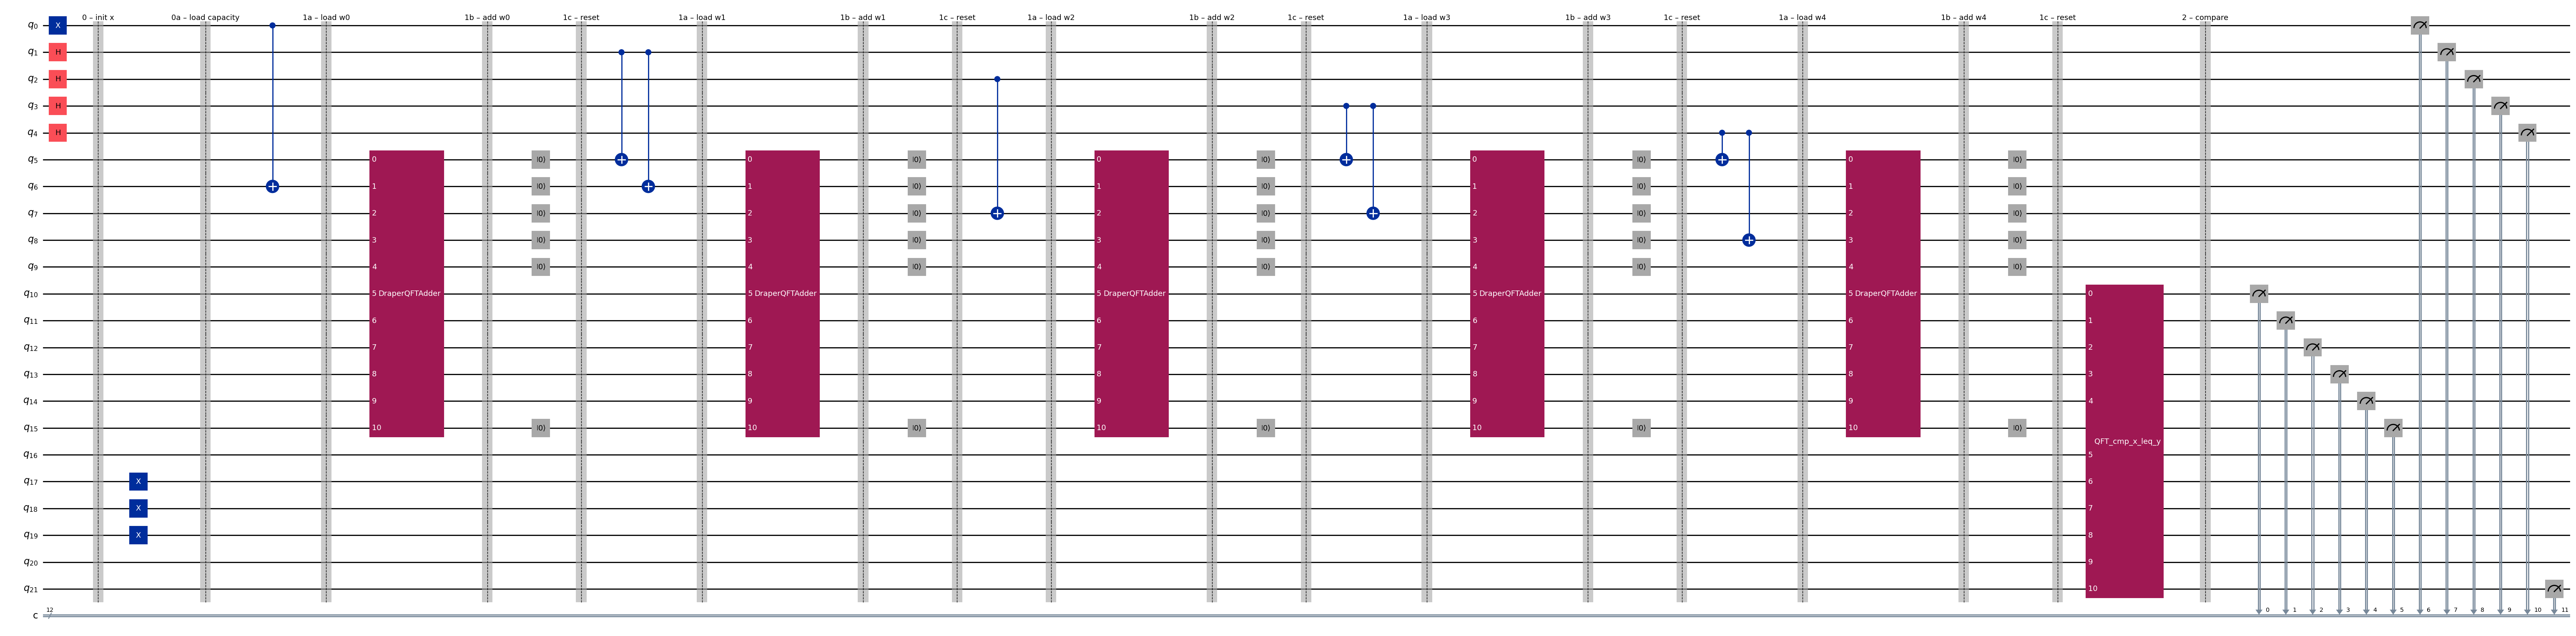

In [10]:
# Part 2 · Build the knapsack circuit (22 qubits, 12 classical bits) ────────
weights, capacity, n_bits = [2, 3, 4, 5, 9], 14, 5

# helper: add / sub register in QFT basis
def qftadd(circ, tgt_idx, src_idx, subtract=False):
    sign = -1 if subtract else 1
    for i, si in enumerate(src_idx):
        for j in range(i, len(tgt_idx)):
            circ.cp(sign * 2*math.pi / 2**(j - i + 1), si, tgt_idx[j])

# helper: QFT comparator (flag = 1 ⇔ x ≤ y) — indices only
def qft_cmp_instr(n: int):
    cmp_circ = QuantumCircuit(2*n + 1, name="QFT_cmp_x_leq_y")
    x   = list(range(0, n))
    y   = list(range(n, 2*n))
    f   = 2*n
    ext = x + [f]

    cmp_circ.append(QFT(len(ext), do_swaps=False), ext)
    qftadd(cmp_circ, ext, y, subtract=True)
    cmp_circ.append(QFT(len(ext), do_swaps=False).inverse(), ext)

    cmp_circ.append(QFT(n, do_swaps=False), x)
    qftadd(cmp_circ, x, y, subtract=False)
    cmp_circ.append(QFT(n, do_swaps=False).inverse(), x)

    cmp_circ.x(f)
    return cmp_circ.to_instruction(label="QFT_cmp_x_leq_y")

cmp_gate = qft_cmp_instr(n_bits)
adder    = DraperQFTAdder(n_bits, kind="half")

# qubit map ───────────────────────────────────────────────────────────────
# 0-4 : x selection       5-9 : Wt_Vt   10-14 : ws_vs   15 : carry
# 16-20 : capacity        21  : comparator flag
qc = QuantumCircuit(22, 12)

# 0) initialise selection |1⟩⊗H⊗H⊗H⊗H
qc.x(0)
qc.h(range(1, 5))
qc.barrier(label="0 – init x")

# 0a) load |capacity⟩ = 14 (01110₂) into qubits 16-20 (LSB→MSB)
for i, bit in enumerate(format(capacity, f"0{n_bits}b")[::-1]):
    if bit == "1":
        qc.x(16+i)
qc.barrier(label="0a – load capacity")

# 1) iterate through items
for idx, w in enumerate(weights):
    bits = format(w, f"0{n_bits}b")[::-1]          # LSB-first

    # 1a) conditional load weight into Wt_Vt (5-9)
    for j, bit in enumerate(bits):
        if bit == "1":
            qc.cx(idx, 5+j)
    qc.barrier(label=f"1a – load w{idx}")

    # 1b) add Wt_Vt → ws_vs via Draper adder
    qc.compose(adder, list(range(5,10))+list(range(10,15))+[15], inplace=True)
    qc.barrier(label=f"1b – add w{idx}")

    # 1c) reset Wt_Vt & carry
    qc.reset(range(5,10))
    qc.reset(15)
    qc.barrier(label=f"1c – reset")

# 2) compare ws_vs ≤ capacity → flag 21
qc.append(cmp_gate, list(range(10,15))+list(range(16,21))+[21])
qc.barrier(label="2 – compare")

# 3) measurements   c[0-5] ws_vs+carry   c[6-10] selection   c[11] flag
qc.measure(range(10,16), range(0,6))
qc.measure(range(0,5),   range(6,11))
qc.measure(21,            11)
qc.draw("mpl", fold=1)

In [11]:
# Part 3 · Transpile & preview ────────────────────────────────────────────
trans_qc = transpile(qc, backend, optimization_level=3)
display(trans_qc.draw("mpl", fold=160))


c:\Users\km_ha\miniconda3\envs\qpu\lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


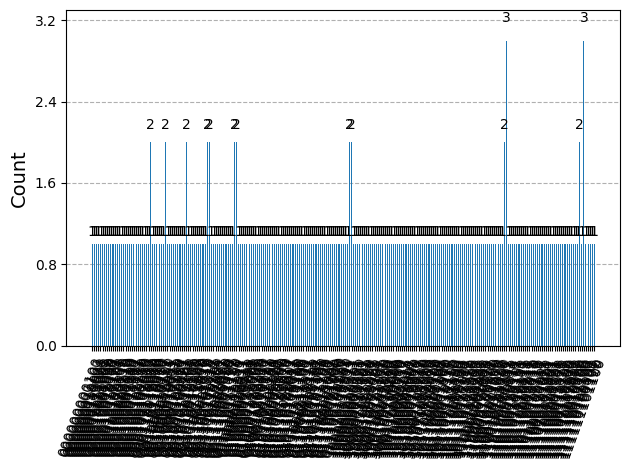

x (MSB→LSB) ws_vs (MSB→LSB) carry  Total weight ≤ capacity flag  Shots
32        00001           00000     0             0               1      1
78        00001           00000     0             0               0      1
127       00010           00000     1             0               1      1
54        00100           00000     1             0               0      1
56        00100           00000     1             0               1      1
..          ...             ...   ...           ...             ...    ...
142       01110           11111     0            31               0      1
50        10010           11111     1            31               1      1
67        10010           11111     0            31               1      2
102       10110           11111     1            31               0      1
11        11100           11111     1            31               0      2

[241 rows x 6 columns]

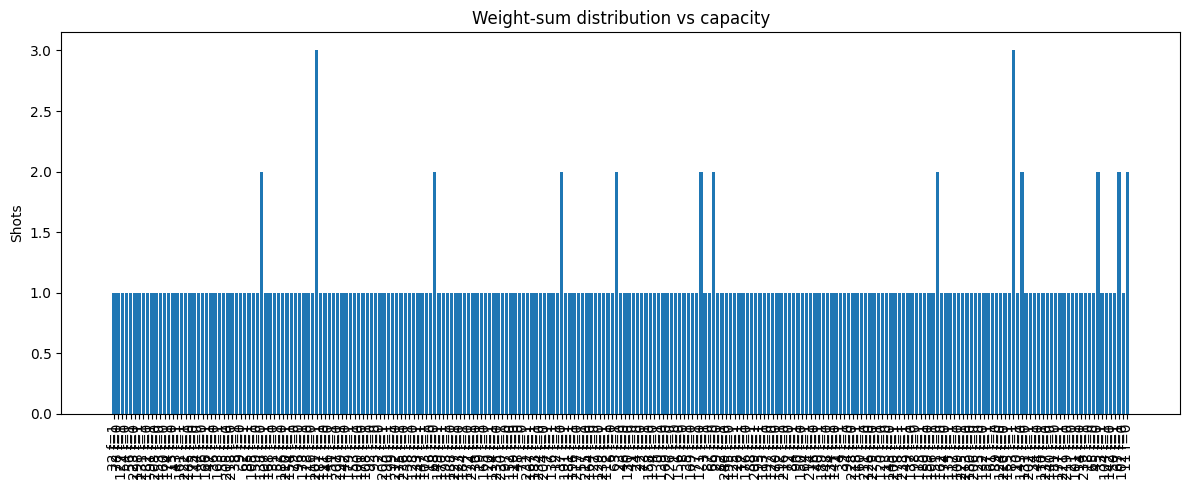


Selections with total weight ≤ 14:


x (MSB→LSB)  Total weight  Shots
32        00001             0      1
127       00010             0      1
56        00100             0      1
198       00110             0      1
231       01000             0      1
..          ...           ...    ...
239       00000            31      1
33        01100            31      1
104       01101            31      1
50        10010            31      1
67        10010            31      2

[114 rows x 3 columns]

In [12]:
# Part 4 · Run with Sampler V2 and analyse counts ────────────────────────
shots   = 256
sampler = SamplerV2(backend)

job         = sampler.run([trans_qc], shots=shots)
pub_result  = job.result()[0]
counts      = pub_result.join_data().get_counts()

# decode bit-strings → DataFrame
rows = []
for s, ct in counts.items():
    bits = s[::-1]                   # LSB-first
    rows.append({
        "x (MSB→LSB)"       : bits[6:11][::-1],
        "ws_vs (MSB→LSB)"   : bits[0:5][::-1],
        "carry"             : bits[5],
        "Total weight"      : int(bits[0:5][::-1], 2),
        "≤ capacity flag"   : bits[11],
        "Shots"             : ct,
    })
df = pd.DataFrame(rows).sort_values(["Total weight", "x (MSB→LSB)"])

display(plot_histogram(counts))
display(df)

plt.figure(figsize=(12,5))
plt.bar(df.index.astype(str)+" f="+df["≤ capacity flag"], df["Shots"])
plt.xticks(rotation=90); plt.ylabel("Shots")
plt.title("Weight-sum distribution vs capacity"); plt.tight_layout(); plt.show()

print("\nSelections with total weight ≤ 14:")
display(df[df["≤ capacity flag"]=="1"][["x (MSB→LSB)", "Total weight", "Shots"]])
